In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.manifold import TSNE
import time

device = torch.device('cpu')

# Set random seed for reproducibility
np.random.seed(1000)
torch.manual_seed(1000)

# Define the dimension
dim = 8

# Define transformations for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors ([0, 255] -> [0.0,1.0])
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 60000  # Load all data at once
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=len(test_dataset), shuffle=False)

# Get the data
for images, labels in train_loader:
    x_train = images  # [60000, 1, 28, 28]
    y_train = labels  # [60000]
    break

for images, labels in test_loader:
    x_test = images  # [10000, 1, 28, 28]
    y_test = labels  # [10000]
    break

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_test_copy = x_test.clone()  # Save a copy of x_test for later use

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Binarize the images
temp_x_train = x_train.clone()
temp_x_train[temp_x_train > 0.5] = 1
temp_x_train[temp_x_train <= 0.5] = 0

temp_x_test = x_test.clone()
temp_x_test[temp_x_test > 0.5] = 1
temp_x_test[temp_x_test <= 0.5] = 0

# Flatten the images
x_train = x_train.view(-1, 28*28)
x_test = x_test.view(-1, 28*28)

# Save labels before any modification
y_train_save = y_train.clone()
y_test_save = y_test.clone()

# Add random noise to the training data
np.random.seed(1000)
a = (np.random.rand(x_train.shape[0], x_train.shape[1]) > 0.3).astype(float)
a = torch.from_numpy(a).float()
x_train = torch.max(a, x_train)

# Convert each input into 8 dimensions
def convert_to_8dim(x, dim=8):
    x_new = torch.zeros(x.size(0), x.size(1), dim)
    a2 = (x * ((2**dim)*1 - 1e-10)).int()
    for i in range(dim):
        x_new[:, :, i] = a2 % 2
        a2 = a2 // 2
    x_new = x_new.view(-1, 28*28*dim)
    return x_new

x_train = convert_to_8dim(x_train, dim)
x_test = convert_to_8dim(x_test, dim)

print(f"x_train shape after conversion: {x_train.shape}")
print(f"x_test shape after conversion: {x_test.shape}")

# Set targets to inputs (autoencoder) AFTER conversion
y_train = x_train.clone()
y_test = x_test.clone()

print(f"y_train shape after setting targets: {y_train.shape}")
print(f"y_test shape after setting targets: {y_test.shape}")



x_train shape: torch.Size([60000, 1, 28, 28]), y_train shape: torch.Size([60000])
x_test shape: torch.Size([10000, 1, 28, 28]), y_test shape: torch.Size([10000])
x_train shape after conversion: torch.Size([60000, 6272])
x_test shape after conversion: torch.Size([10000, 6272])
y_train shape after setting targets: torch.Size([60000, 6272])
y_test shape after setting targets: torch.Size([10000, 6272])


In [5]:
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.dim = dim
        self.input_size = 28*28*self.dim
        self.fc1 = nn.Linear(self.input_size * 2, 100)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(400, 100)
        self.fc4 = nn.Linear(400, 100)
        self.fc5 = nn.Linear(400, 100)
        self.fc6 = nn.Linear(200, 100)
        self.fc7 = nn.Linear(400, 100)
        self.fc8 = nn.Linear(400, 100)
        self.fc9 = nn.Linear(400, 100)
        self.fc10 = nn.Linear(400, 100)
        self.fc_out = nn.Linear(200, self.input_size)
        
        # Non-negative weight initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=0, b=0.05)
                nn.init.constant_(m.bias, 0)
        
        # List of layers to enforce non-negative weights
        self.nonneg_modules = [self.fc1, self.fc2, self.fc3, self.fc4, self.fc5,
                               self.fc6, self.fc7, self.fc8, self.fc9, self.fc10, self.fc_out]
    
    def forward(self, x, return_intermediate=False):
        x_in = x
        x_neg = -x_in
        x_cat = torch.cat((x_in, x_neg), dim=1)
        x = torch.relu(self.fc1(x_cat))
        x_neg = -x
        x_cat = torch.cat((x, x_neg), dim=1)
        x1 = torch.relu(self.fc2(x_cat))
        x1_neg = -x1
        x_cat = torch.cat((x1, x1_neg, x, x_neg), dim=1)
        x2 = torch.relu(self.fc3(x_cat))
        x2_neg = -x2
        x_cat = torch.cat((x2, x2_neg, x, x_neg), dim=1)
        x3 = torch.relu(self.fc4(x_cat))
        if return_intermediate:
            return x3
        x3_neg = -x3
        x_cat = torch.cat((x3, x3_neg, x, x_neg), dim=1)
        x4 = torch.relu(self.fc5(x_cat))
        x4_neg = -x4
        x_cat = torch.cat((x4, x4_neg), dim=1)
        x5 = torch.relu(self.fc6(x_cat))
        x5_neg = -x5
        x_cat = torch.cat((x5, x5_neg), dim=1)
        x6 = torch.relu(self.fc7(torch.cat((x5, x5_neg, x5, x5_neg), dim=1)))
        x6_neg = -x6
        x_cat = torch.cat((x6, x6_neg, x5, x5_neg), dim=1)
        x7 = torch.relu(self.fc8(x_cat))
        x7_neg = -x7
        x_cat = torch.cat((x7, x7_neg, x5, x5_neg), dim=1)
        x8 = torch.relu(self.fc9(x_cat))
        x8_neg = -x8
        x_cat = torch.cat((x8, x8_neg, x5, x5_neg), dim=1)
        x9 = torch.relu(self.fc10(x_cat))
        x9_neg = -x9
        x_cat = torch.cat((x9, x9_neg), dim=1)
        x_out = torch.sigmoid(self.fc_out(x_cat))
        return x_out
    
    def clamp_weights(self):
        # Enforce non-negative weights
        for m in self.nonneg_modules:
            m.weight.data.clamp_(0)
    
    def reconstruct_image(self, x_out):
        x_out2 = x_out.view(-1, 28, 28, self.dim)
        x_out3 = sum([x_out2[:, :, :, i] * (2 ** i) for i in range(self.dim)]) / 256
        x_out3 = x_out3.view(-1, 28*28)
        return x_out3


Epoch [1/100], Loss: 0.06128503032228764
Epoch [2/100], Loss: 0.0002503501085933143
Epoch [3/100], Loss: 0.00025018364383261847
Epoch [4/100], Loss: 0.00025013466976815836
Epoch [5/100], Loss: 0.0002501200173719553
Epoch [6/100], Loss: 0.00025011406634196947
Epoch [7/100], Loss: 0.0002501111471186353
Epoch [8/100], Loss: 0.00025010953761617807
Epoch [9/100], Loss: 0.00025010856331694715
Epoch [10/100], Loss: 0.00025010793431041144
Epoch [11/100], Loss: 0.0002501075069085346
Epoch [12/100], Loss: 0.00025010721183207354
Epoch [13/100], Loss: 0.00025010699464473874
Epoch [14/100], Loss: 0.00025010683630777444
Epoch [15/100], Loss: 0.00025010672202673353
Epoch [16/100], Loss: 0.0002501066287550202
Epoch [17/100], Loss: 0.00025010655307899774
Epoch [18/100], Loss: 0.00025010648832297493
Epoch [19/100], Loss: 0.00025010644624368674
Epoch [20/100], Loss: 0.0002501064113494067
Epoch [21/100], Loss: 0.00025010637734036815
Epoch [22/100], Loss: 0.00025010634959471645
Epoch [23/100], Loss: 0.0002

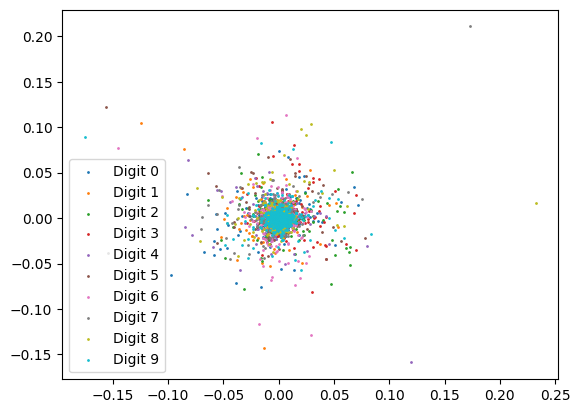

[t-SNE] Computing 10 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.686272
[t-SNE] KL divergence after 1000 iterations: 1.653003


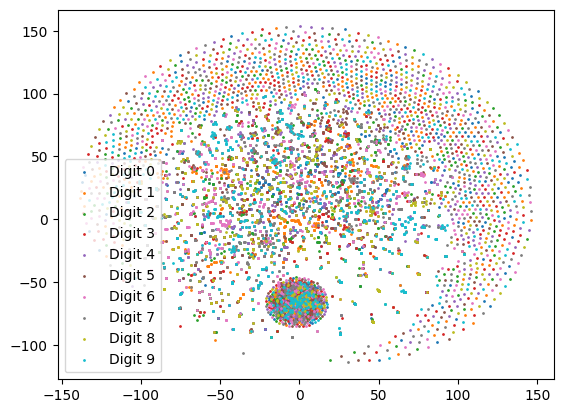

/home/knightz33/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-2031.745415152497571 > -2050.887995442925785). You may want to try with a higher value of support_fraction (current value: 0.508).
  warnings.warn(
/home/knightz33/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-2003.823327829857135 > -2024.420594355948879). You may want to try with a higher value of support_fraction (current value: 0.508).
  warnings.warn(
/home/knightz33/.pyenv/versions/3.11.1/lib/python3.11/site-packages/sklearn/covariance/_robust_covariance.py:186: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-2232.473548611376827 > -2343.645366003015170). You may want to try w

ValueError: cannot reshape array of size 25690112 into shape (28,28)

In [7]:

# Instantiate the model, define the optimizer and loss function
model = Autoencoder()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

# Prepare data loaders for training
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        model.clamp_weights()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader)}")

# Extract intermediate outputs for visualization
model.eval()
with torch.no_grad():
    test_mid = model(x_test, return_intermediate=True)
test_mid_np = test_mid.cpu().numpy()

# SVD whitening
def svd_whiten(X):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    X_white = np.dot(U, Vt)
    return X_white

test_mid_np = svd_whiten(test_mid_np)
print(f"Whitened shape: {test_mid_np.shape}")

# PCA for visualization
pca = PCA(n_components=2)
test_mid2 = pca.fit_transform(test_mid_np)



# Plot PCA results
labels = y_test_save.numpy()
for i in range(10):
    plt.scatter(test_mid2[labels == i, 0], test_mid2[labels == i, 1], s=1, label=f"Digit {i}")
plt.legend()
plt.show()

# t-SNE visualization
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3, verbose=1).fit_transform(test_mid_np)
for i in range(10):
    plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], s=1, label=f"Digit {i}")
plt.legend()
plt.show()

# Fit a robust covariance estimator
robust_cov = MinCovDet().fit(test_mid_np)
cov = robust_cov.covariance_
mea = np.mean(test_mid_np, axis=0)

# Function to binarize images
def binarized(x_test):
    x_test_new = torch.zeros(x_test.size(0), x_test.size(1), dim)
    a2 = (x_test * ((2**dim)*1 - 1e-10)).int()
    for i in range(dim):
        x_test_new[:, :, i] = a2 % 2
        a2 = a2 // 2
    x_test_new = x_test_new.view(-1, 28*28*dim)
    return x_test_new

# Generate images by interpolating between two random latent vectors
np.random.seed(int(time.time()))
n = 2
b = (np.floor(np.random.rand(n) * len(x_test))).astype(int)
x_test_tempo = x_test[b, :].clone()
with torch.no_grad():
    test_mid = model(x_test_tempo, return_intermediate=True)

test_out_big = np.zeros((28*1, 28*100))
for i in range(100):
    b2 = np.array([i / 99, 1 - i / 99])
    temp = (test_mid * torch.from_numpy(b2).float().view(n, 1)).sum(dim=0).unsqueeze(0)
    temp_neg = -temp
    temp_cat = torch.cat((temp, temp_neg), dim=1)
    with torch.no_grad():
        test_out = torch.sigmoid(model.fc_out(temp_cat))
    
    # Include binarization steps
    for repeat in range(5):
        a = (np.random.rand(test_out.shape[0], test_out.shape[1]) > 0.4).astype(float)
        a = torch.from_numpy(a).float()
        test_out = torch.max(a, test_out)
        test_out = binarized(test_out)
        with torch.no_grad():
            test_out = model(test_out)
    
    test_out_img = model.reconstruct_image(test_out)
    test_out_img = test_out_img.cpu().numpy().reshape(28, 28)
    test_out_big[0*28:(0+1)*28, i*28:(i+1)*28] = test_out_img

plt.figure(figsize=(15, 2))
plt.imshow(test_out_big, cmap='gray')
plt.title('Interpolation between two images')
plt.axis('off')
plt.show()

# Generate images from random latent vectors
np.random.seed(int(time.time()))
n = 1
with torch.no_grad():
    test_mid2 = np.random.multivariate_normal(mea + (2 * np.random.rand(100) - 1), cov, size=1)
    test_mid = torch.from_numpy(test_mid2).float()

test_out_big = np.zeros((28*1, 28*100))
for i in range(100):
    temp = test_mid
    temp_neg = -temp
    temp_cat = torch.cat((temp, temp_neg), dim=1)
    with torch.no_grad():
        test_out = torch.sigmoid(model.fc_out(temp_cat))
    
    # Include binarization steps
    for repeat in range(5):
        a = (np.random.rand(test_out.shape[0], test_out.shape[1]) > 0.4).astype(float)
        a = torch.from_numpy(a).float()
        test_out = torch.max(a, test_out)
        test_out = binarized(test_out)
        with torch.no_grad():
            test_out = model(test_out)
    
    test_out_img = model.reconstruct_image(test_out)
    test_out_img = test_out_img.cpu().numpy().reshape(28, 28)
    test_out_big[0*28:(0+1)*28, i*28:(i+1)*28] = test_out_img

plt.figure(figsize=(15, 2))
plt.imshow(test_out_big, cmap='gray')
plt.title('Generated images from random latent vectors')
plt.axis('off')
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title):
    img = img * 0.5 + 0.5  # Unnormalize to [0,1]
    npimg = img.cpu().numpy()
    # Select the first channel (if grayscale) or handle the display for multi-channel data
    plt.imshow(npimg[0], cmap='gray')  # Displaying the first channel
    plt.title(title)
    plt.axis('off')

dataiter = iter(test_loader)
images, _ = next(dataiter)  
images = images.to(device)

# Get reconstructed images
with torch.no_grad():
    outputs = model(images.to(device))

plt.figure(figsize=(10, 4))
for idx in range(8):
    plt.subplot(2, 8, idx+1)
    imshow(images[idx], 'Original')  # Display only the first channel

for idx in range(8):
    plt.subplot(2, 8, idx+9)
    imshow(outputs[idx], 'Reconstructed')  # Display only the first channel

plt.tight_layout()
plt.show()


In [8]:
model.eval()
test_loss = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Test Reconstruction Loss: {test_loss}")

Test Reconstruction Loss: 0.0009061702797771432


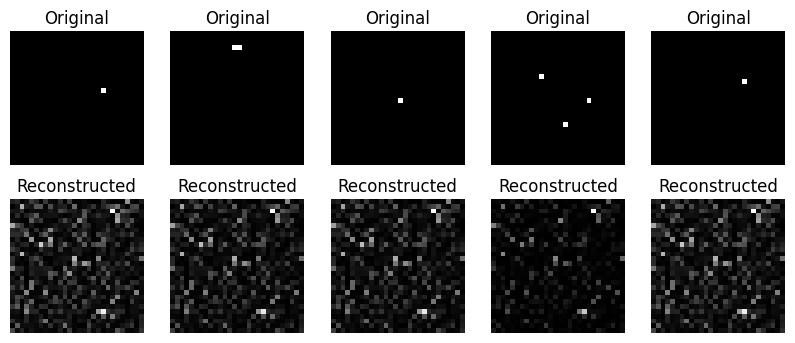

In [9]:
# Visualize original and reconstructed images
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    outputs = model(inputs)
    outputs_img = model.reconstruct_image(outputs)
    inputs_img = model.reconstruct_image(inputs)

# Display images
n = 5  # Number of images to display
plt.figure(figsize=(10, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(inputs_img[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(outputs_img[i].cpu().numpy().reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
plt.show()
